### Langchain + RAG 구현

RAG의 과정은 아래와 같이 진행됩니다.
1. Indexing : 문서를 받아 검색이 잘 되도록 저장합니다.
1. Processing : 입력 쿼리를 전처리하여 검색에 적절한 형태로 변환합니다<br>(여기서는 수행하지 않습니다)
1. Search(Retrieval) : 질문이 주어진 상황에서 가장 필요한 참고자료를 검색합니다.
1. Augmenting : Retrieval의 결과와 입력 프롬프트를 이용해 LLM에 전달할 프롬프트를 생성합니다.
1. Generation : LLM이 출력을 생성합니다.

### 라이브러리 설치

`sentence_transformers`: 트랜스포머 계열의 공개 임베딩 모델을 사용할 수 있습니다.    
`langchain_chroma`: ChromaDB를 이용해 벡터 데이터베이스를 구성합니다.

In [1]:
!pip install -q ragas sacrebleu dotenv langchain_huggingface sentence_transformers jsonlines langchain langchain-openai langchain-community beautifulsoup4 langchain_chroma

In [22]:
import openai
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

client = openai.OpenAI()
# API 키 검증하기
try: client.models.list(); print("OPENAI_API_KEY가 정상적으로 설정되어 있습니다.")
except:  print(f"OpenAI API 키가 유효하지 않습니다!")

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.3)


OPENAI_API_KEY가 정상적으로 설정되어 있습니다.


RAG 검색을 위해서는 임베딩 모델이 필요합니다. 
<br />
아래의 openai 의 text-embedding-3-large 는 빠르게 연산하지만 유료입니다. 내부망에서는 공개 임베딩 모델을 이용해야합니다.

In [23]:
from langchain_openai import OpenAIEmbeddings
openai_embeddings = OpenAIEmbeddings(model='text-embedding-3-large', chunk_size=100)

아래는 허깅페이스에 배포된 공개 모델입니다.
- 파라미터 수 : 큰 임베딩 모델의 크기는 LLM에 육박합니다. GPU를 고려하여 선택합니다.
- Max Tokens: 임베딩 모델의 최대 토큰보다 큰 데이터를 입력하면, 앞부분만을 이용해 계산하게 되므로 적절한 검색이 되지 않을 수 있습니다.
- 임베딩 차원: 큰 차원의 벡터를 생성하는 임베딩 모델은 검색 속도가 감소합니다.

현재 한국어 데이터를 임베딩하기 위해 자주 사용하는 모델은 아래와 같습니다.

- Multilingual-E5-Small (500MB, 514 토큰 제한)   
Multilingual-E5 시리즈는 마이크로소프트의 다국어 공개 임베딩 모델입니다.

- BGE-M3 (2GB, 8194 토큰 제한)   
BGE-M3 시리즈는 BAAI의 임베딩 모델로, 현재 가장 인기가 많은 모델입니다.

- KURE-V1 (2GB, 8194 토큰 제한)    
KURE 임베딩은 고려대학교 NLP 연구실에서 만든 모델로, BGE-M3를 한국어 텍스트로 파인 튜닝한 모델입니다.


In [7]:
from sentence_transformers import SentenceTransformer

model_name = 'BAAI/bge-m3'
#실제 주소: https://huggingface.co/BAAI/bge-m3

# CPU 설정으로 모델 불러오기
emb_model = SentenceTransformer(model_name, device='cpu')

# 로컬 폴더에 모델 저장하기
emb_model.save('./embedding')

# 모델 메모리에서 삭제
del emb_model
import gc
gc.collect()

7463

In [61]:
from langchain_huggingface import HuggingFaceEmbeddings

# 허깅페이스 포맷의 임베딩 모델 불러오기
open_embeddings = HuggingFaceEmbeddings(
    model_name = './embedding',
    model_kwargs = {'device':'mps'}   # gpu 사용하기
)

### 데이터 수집 및 전처리

벡터 DB 에 저장할 데이터를 수집하고 전처리합니다. 여기서는 실제로 수행하지 않고 아래 과정을 통해 저장된 데이터를 이용합니다.

네이버 뉴스 링크 수집(['url']) <br />
-> WebBaseLoader 를 통해 url 별 컨텐츠 수집 ([Document(metadata={'source': 'https://n.news.naver.com/mnews/article/022/0004058492?sid=100'}, page_content='\n\n\n\n\n세계일보\n\n세계일보\n\n\n구독\n\n세계일보 언론사 구독되었습니다. 메인...'),]) <br />
-> 데이터 전처리 및 저장


In [ ]:
import jsonlines
from langchain.schema import Document

def load_docs_from_jsonl(file_path):
    documents = []
    with jsonlines.open(file_path, mode="r") as reader:
        for doc in reader:
            documents.append(Document(**doc))
    return documents

preprocessed_docs = load_docs_from_jsonl("./data/langchain-rag-news-url.jsonl")
len(preprocessed_docs)

241

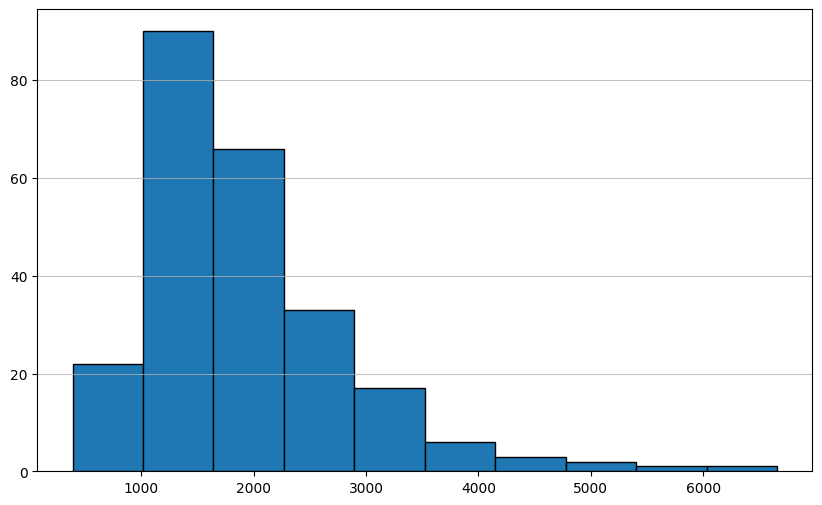

In [63]:
import matplotlib.pyplot as plt
from langchain_core.documents import Document # Langchain Document 클래스 임포트

# 각 문서의 길이를 저장할 리스트
document_lengths = []

# preprocessed_docs 리스트를 순회하며 각 문서의 길이를 계산
for doc in preprocessed_docs:
    document_lengths.append(len(doc.page_content))

# 문서 길이 히스토그램 그리기
plt.figure(figsize=(10, 6)) # 그래프 크기 설정
plt.hist(document_lengths, bins=10, edgecolor='black') # 히스토그램 생성. bins는 막대 개수, edgecolor는 막대 테두리 색상 [1, 3, 4]
plt.grid(axis='y', alpha=0.75) # y축 그리드 표시
plt.show() # 그래프 표시```


### Chunking

전처리가 완료된 docs를 chunk 단위로 분리합니다.
`chunk_size`와 `chunk_overlap`을 이용해 청크의 구성 방식을 조절할 수 있습니다.  

Chunk Size * K(검색할 청크의 수) 의 결과가 Context의 길이가 됩니다.

In [64]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain import hub

# 0~1000, 800~1800, 1600~2600, ...
# 공백, 엔터, 쉼표 등으로 최대한 길이를 맞춰 청킹하는 Splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(preprocessed_docs)

print(len(chunks))  # Top K --> 1000 * K를 Context로 놓고 답변하는 형태

643


### Vector Database 만들기   

구성된 청크를 벡터 데이터베이스에 로드합니다.   

In [66]:
from langchain_chroma import Chroma
from tqdm import tqdm

Chroma().delete_collection() # (메모리에 저장하는 경우) 기존 데이터 삭제

# DB 구성하기
db = Chroma(
    embedding_function=open_embeddings,
    persist_directory="./chroma_open",        # 파일 시스템에 저장 (생략시 메모리에 저장)
    collection_name='Web',                      # 식별 이름
    collection_metadata={'hnsw:space':'l2'},    # l2 메트릭 설정(기본값, cosine, mmr 로 변경 가능)
)

print(len(chunks))

# DB에 document를 추가합니다.    
# OpenAI 임베딩은 30만 토큰 동시 처리 제한이 있어, 나눠서 전달합니다.
# 임베딩 선언시의 청크사이즈 제한으로 해결
db.add_documents(chunks)

643


['4f7e0e79-6ccb-45fa-8148-ff44ec9e366e',
 '574d080e-e964-4711-a4c3-2b7fc426dc1f',
 '5be0c8f4-e40a-49a0-913b-d9370799beff',
 '93381506-c533-457b-afc7-1dd2853c01cf',
 '5d2b55c8-a00c-4351-a68f-7a141c17b132',
 'e8229aa8-b0dc-400a-8319-81c794bfeeb7',
 'b6f53379-a51c-41df-8887-18ff25b78074',
 'c4069b84-b049-4692-80e2-c5a54109679c',
 'd97674a7-b7c8-4c0f-b675-1c0f5996ae97',
 '356a1ca5-346e-4201-a1bb-00d55649e545',
 '70aee0e2-4ca2-4fa6-8db4-b7d343545b00',
 '78d6f4ee-be85-4a8d-ad81-bb0bd60262be',
 '8a1433d8-5615-42ab-a1bd-078088205b6d',
 'ba4eec50-a4a1-42b5-897e-d62474070bf2',
 '26551bd3-7ee2-41fa-9e6c-ed9f5c4087c1',
 '01fc9b2b-d6bd-448b-bf7c-30f16ffb6101',
 '895a0f88-4741-43da-a2a1-5847651c57db',
 '2d41b557-25b0-4a12-af86-91ba40992d5f',
 'fa946eaa-53d9-4e4f-ae4f-fd179f53bf40',
 'f5b7dc58-cd42-4b10-b014-063df1d2850e',
 '7e4a68aa-4732-452b-9a20-392107ec322b',
 '350b6cab-736d-4294-858f-4c5e368ec8c8',
 '9e49ea1e-9d95-45c0-a753-6bcf7de8999b',
 '6ecb60a8-5fa1-464c-a9b6-dc806ca525e9',
 '68f3ed1a-ec49-

In [67]:
# db 를 통해 retriever 구성
# Top 5 Search(기본값은 4)
retriever = db.as_retriever(search_kwargs={'k':5})
retriever.invoke("도메인 특화 언어 모델")

[Document(id='085b5b89-7f04-4a93-8982-9feff4001af6', metadata={'source': 'https://n.news.naver.com/mnews/article/031/0000916729?sid=105'}, page_content='오히려 공개된 모델을 활용해 특정 서비스를 개발하는 것이 가능성이 높다는 설명이다. 정 이사는 "딥시크 R1과 같은 고성능의 오픈소스 모델들이 나오면서 이를 활용해 개발하는 AI 서비스로는 한국 기업들도 충분히 경쟁력이 있다"면서 "특히 도메인 특화 모델은 국내 뿐만 아니라 글로벌에서도 충분히 가치를 인정받을 수 있다"고 말했다.그는 "도메인 특화 모델은 챗GPT와 같은 범용 모델과 비교해 전문성을 갖춘 답변을 제공하며, 학습 비용과 시간도 크게 절감할 수 있다"고 강조했다. 예를 들어 의료 도메인 특화 모델은 암진단과 치료를 돕기 위해 환자의 의료 데이터, 임상 시험 결과를 학습시킨 모델이다. 법률 도메인 특화 모델은 판례, 법률 계약, 법 규정을 학습시켜 법률가의 연구시간을 절약해 준다.정 이사는 "일반적인 LLM이 정규교육을 받은 고등학생이라면 도메인 특화 모델은 그 분야를 전공한 대학생이라고 생각하면 쉽다"며 "도메인 특화 모델을 활용하면 그 분야의 전문가를 교육하는 시간과 비용을 크게 줄일 수 있게 되는 것"이라고 설명했다."제조·유통에서 금융·공공까지 확장 가능"빅데이터·AI 기업 S2W는 이러한 도메인 특화 모델 개발 기술로 주목을 받고 있다. 대표 제품은 세계 최초 다크웹 특화 모델 \'다크버트\'다. 이른바 \'인터넷의 암시장\'으로도 불리는 다크웹은 구글이나 네이버 등 일반적인 검색 엔진으로 접근할 수 없고 특정 소프트웨어(SW)나 네트워크 권한이 있어야 접속할 수 있는 영역이다. 익명성이 보장되기 때문에 성범죄, 마약 거래, 해킹 커뮤니티 등 불법적인 활동이 활발하다.S2W는 다크웹에서 시작한 도메인 특화 모델 개발 기술을 현대제철, 롯데멤버스 등 다양한 산업 분야로 확장

### RAG 테스트

지금까지 구성한 벡터 DB 를 통해 RAG 를 수행합니다.

In [68]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from rich import print as rp

# retriever의 결과물은 List[Document] 이므로 이를 ---로 구분하는 함수
# metadata의 source를 보존하여 추가
def format_docs(docs):
    return " \n\n---\n\n ".join([
        'URL: '+ doc.metadata['source'] + '\n Content:' +  doc.page_content for doc in docs])

prompt = ChatPromptTemplate([
    ("user", '''당신은 QA(Question-Answering)을 수행하는 Assistant입니다.
다음의 Context를 이용하여 Question에 답변하세요.
정확한 답변을 제공하세요.
만약 모든 Context를 다 확인해도 정보가 없다면,
"정보가 부족하여 답변할 수 없습니다."를 출력하세요.
---
Context: {context}
---
Question: {question}''')])

rag_chain = (
    # retriever : question을 받아서 context 검색: document 반환
    # format_docs : document 형태를 받아서 텍스트로 변환
    # RunnablePassthrough(): 체인의 입력을 그대로 저장
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rp(rag_chain.invoke("도메인 특화 언어 모델이란 무엇입니까? 어떤 예시가 있나요?"))
rp(rag_chain.invoke("2030년 삼성전자 주가는?"))

도메인 특화 언어 모델이란 특정 산업이나 전문 분야의 지식, 데이터, 용어를 AI에 학습시켜 해당 영역에 최적화된 AI 
모델을 말합니다. 범용 모델(예: 챗GPT)과 비교해 전문성을 갖춘 답변을 제공하며, 학습 비용과 시간도 크게 절감할 수 
있다는 장점이 있습니다.

예시로는  
- 의료 도메인 특화 모델: 암 진단과 치료를 돕기 위해 환자의 의료 데이터와 임상 시험 결과를 학습한 모델  
- 법률 도메인 특화 모델: 판례, 법률 계약, 법 규정을 학습해 법률가의 연구 시간을 절약해 주는 모델  
- 다크웹 특화 모델 '다크버트': 다크웹의 불법 활동을 분석하기 위해 개발된 세계 최초의 다크웹 특화 모델

이 외에도 제조, 유통, 금융, 공공 등 다양한 산업 분야로 확장 가능하다고 합니다.

정보가 부족하여 답변할 수 없습니다.

만약 Context가 포함된 RAG 결과를 보고 싶다면, RunnableParallel을 사용하면 됩니다. <br />
assign()을 이용하면, 체인의 결과를 받아 새로운 체인에 전달하고, 그 결과를 가져옵니다.

In [69]:
# assign : 결과를 받아서 새로운 인수 추가하고 원래 결과와 함께 전달

from langchain_core.runnables import RunnableParallel

rag_chain_from_docs = (
    prompt
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

# retriever의 실행 결과를 rag_chain_from_docs 에 넘겨주기 때문에 retriever가 1번 실행됨
rag_chain_with_source.invoke("인공지능의 최근 발전 방식은? 관련 링크도 보여주세요")

{'context': 'URL: https://n.news.naver.com/mnews/article/029/0002896514?sid=105\n Content:움직임이 빨라지고 있다. 기존 데이터 기반의 4세대 연구에서 데이터·AI 기반의 5세대 연구로 패러다임이 전환되면서 AI 기술은 사람의 능력으로 불가능했던 새로운 발견과 문제 해결을 위한 혁신 도구로 역할을 확대하고 있다. 지난해 12월에는 미국 카네기멜론대 연구팀이 LLM를 활용해 새로운 화학물질을 만들기 위한 실험을 AI를 활용해 설계·계획·수행하는 \'코사이언티스트(협력과학자) 시스템\'을 개발해 눈길을 끌었다. 이 시스템은 관련 논문과 참고문헌을 검색·분류해 정리한 뒤, 클라우드로 연결된 로봇 시스템을 활용해 24시간 쉬지 않고 자율적으로 실험을 진행하며, 화학적 촉매 반응을 일으키는 실험에도 성공했다.미국 버클리대 연구팀은 텍스트마이닝 기법을 이용해 원하는 물질의 제조법을 파악한 뒤 실험실 내 로봇을 조정해 제조토록 하는 \'자율 실험실\'을 구축하기도 했다. 구글 딥마인드는 AI를 활용해 단백질의 3차원 구조를 예측하고 모델링하는 \'알파폴드\'를 고도화하면서 세상에 존재하는 혁신 신약 개발 기간과 비용을 절감하는 데 기여하고 있다. 이처럼 LLM은 생명과학과 자연과학, 공학 등 과학기술 전반에 걸쳐 연구생산성과 효율성을 높이는 데 실질적인 도움을 주고 있다. 이 가운데 방대한 양의 연구정보를 데이터와 AI 기반의 연구를 통해 자동 추출·분석·추론함으로써 과학기술적 난제 해결과 과학기술 산업 혁신을 위한 초거대 AI 기술 확보와 시장 선점 경쟁이 거세지고 있다.◇과학기술 특화 생성형 LLM \'고니\'…환각현상 최소화A: "너는 요즘 무엇을 이용해 과학기술정보를 찾니?"B: "챗GPT 등 생성형 AI를 자주 이용하지. 그런데, 챗GPT는 간혹 잘못된 정보를 찾아줘 골치가 아파."A: "\'고니(KONI)\'라고 들어봤어? 난 요즘 이걸 자주 이용해. 과학기술 분야에 특화된 거대언어모델(LLM

### RAG 성능 평가하기

RAGAS (https://docs.ragas.io/en/stable/)는 다양한 메트릭을 통한 RAG의 성능 평가를 지원합니다.

RAG의 평가를 위해서는 정답이 있는 Q/A 데이터가 필요합니다.   
실습 시트에서 langchain-rag-news-url-eval.csv 을 다운로드하여 불러옵니다.

In [ ]:
import pandas as pd
df = pd.read_csv('./data/langchain-rag-news-url-eval.csv')
eval_dataset = df.to_dict('list')
eval_dataset

{'questions': ['도메인 특화 언어 모델이란 무엇입니까? 어떤 예시가 있나요?',
  '인공지능의 최근 발전 방식은? 관련 링크도 보여주세요',
  '제미나이 2.5 버전의 장점은 무엇입니까?',
  '고니 모델의 파라미터 수는 몇 개입니까?',
  '업스테이지의 대표는 누구입니까?',
  'AI 가전의 3가지 핵심가치는?',
  '지브리 풍의 그림을 그려주는 AI는 무엇입니까?',
  'ChatGPT가 처한 저작권 위기는 무엇입니까?'],
 'ground_truths': ["도메인 특화 AI란 특정 산업이나 전문 분야의 지식, 데이터, 용어를 AI에 학습시켜 해당 영역에 최적화된 AI를 말합니다.\n\n예시:\n*   의료 도메인 특화 모델: 암 진단과 치료를 돕기 위해 환자의 의료 데이터, 임상 시험 결과를 학습시킨 모델\n*   법률 도메인 특화 모델: 판례, 법률 계약, 법 규정을 학습시켜 법률가의 연구시간을 절약해 줌\n*   다크웹 특화 모델: S2W의 '다크버트'",
  '인공지능은 최근 추론형 AI 모델로 발전하고 있으며, 이는 응답하기 전에 사고하는 방식을 통해 성능과 정확도를 높이는 데 중점을 두고 있습니다.\n\n관련 기사 링크:\n\n*   구글, 사고형 AI ‘제미나이 2.5’ 공개… “가장 지능적인 모델”: [https://n.news.naver.com/mnews/article/366/0001064042?sid=105](https://n.news.naver.com/mnews/article/366/0001064042?sid=105)\n*   구글, 최신 AI 모델 제미나이 2.5 공개…"가장 지능적 모델": [https://n.news.naver.com/mnews/article/001/0015289685?sid=104](https://n.news.naver.com/mnews/article/001/0015289685?sid=104)\n*   구글, 최신 AI 모델 제미나이 2.5 공개: [https://n.news.naver.c

In [71]:
questions, ground_truths = eval_dataset['questions'], eval_dataset['ground_truths']

In [72]:
dataset = []

for query,reference in zip(questions,ground_truths):

    relevant_docs = [doc.page_content for doc in retriever.invoke(query)]
    response = rag_chain.invoke(query)
    dataset.append(
        {
            # 질문, 검색 결과, RAG 파이프라인의 답변, 정답
            "user_input":query,
            "retrieved_contexts":relevant_docs,
            "response":response,
            "reference":reference
        }
    )
dataset

[{'user_input': '도메인 특화 언어 모델이란 무엇입니까? 어떤 예시가 있나요?',
  'retrieved_contexts': ['오히려 공개된 모델을 활용해 특정 서비스를 개발하는 것이 가능성이 높다는 설명이다. 정 이사는 "딥시크 R1과 같은 고성능의 오픈소스 모델들이 나오면서 이를 활용해 개발하는 AI 서비스로는 한국 기업들도 충분히 경쟁력이 있다"면서 "특히 도메인 특화 모델은 국내 뿐만 아니라 글로벌에서도 충분히 가치를 인정받을 수 있다"고 말했다.그는 "도메인 특화 모델은 챗GPT와 같은 범용 모델과 비교해 전문성을 갖춘 답변을 제공하며, 학습 비용과 시간도 크게 절감할 수 있다"고 강조했다. 예를 들어 의료 도메인 특화 모델은 암진단과 치료를 돕기 위해 환자의 의료 데이터, 임상 시험 결과를 학습시킨 모델이다. 법률 도메인 특화 모델은 판례, 법률 계약, 법 규정을 학습시켜 법률가의 연구시간을 절약해 준다.정 이사는 "일반적인 LLM이 정규교육을 받은 고등학생이라면 도메인 특화 모델은 그 분야를 전공한 대학생이라고 생각하면 쉽다"며 "도메인 특화 모델을 활용하면 그 분야의 전문가를 교육하는 시간과 비용을 크게 줄일 수 있게 되는 것"이라고 설명했다."제조·유통에서 금융·공공까지 확장 가능"빅데이터·AI 기업 S2W는 이러한 도메인 특화 모델 개발 기술로 주목을 받고 있다. 대표 제품은 세계 최초 다크웹 특화 모델 \'다크버트\'다. 이른바 \'인터넷의 암시장\'으로도 불리는 다크웹은 구글이나 네이버 등 일반적인 검색 엔진으로 접근할 수 없고 특정 소프트웨어(SW)나 네트워크 권한이 있어야 접속할 수 있는 영역이다. 익명성이 보장되기 때문에 성범죄, 마약 거래, 해킹 커뮤니티 등 불법적인 활동이 활발하다.S2W는 다크웹에서 시작한 도메인 특화 모델 개발 기술을 현대제철, 롯데멤버스 등 다양한 산업 분야로 확장했다. 온톨로지와 RAG(검색 증강 생성)를 결합한 기술을 적용해 성능을 높였다. 온톨로지는 특정 분야의 개념과 그 관계를 체계적으로

RAGAS는 LLM을 이용해 정답과 답변을 개별 Claim(주장)으로 분할합니다.

이후, `LLMContextRecall`, `Faitufulness`, `FactualCorrectness` 등의 다양한 메트릭을 통해 RAG 파이프라인의 성능을 평가합니다.   
LLM 기반의 방법이므로 평가 LLM의 선정이 중요하며, 절대 수치보다는 상대적 비교가 효과적입니다.


- Context Recall: 정답의 Claim들이 모두 검색됐는가
- Faithfulness : 답변의 Claim이 얼마나 검색 결과에 근거했는가
- Factual Correctness : 정답과 답변의 Claim이 얼마나 일치하는가
- Bleu Score : 정답과 답변 키워드가 얼마나 일치하는가
- Semantic Sim : 정답 답변 임베딩이 얼마나 가까운가   


In [73]:
from ragas import EvaluationDataset, evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness
from ragas.metrics import BleuScore, SemanticSimilarity

evaluation_dataset = EvaluationDataset.from_list(dataset)
print(evaluation_dataset)

# https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/
# 평가자 LLM
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))

# 평가자 Embedding
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model = 'text-embedding-3-large'))
semantic_scorer = SemanticSimilarity(embeddings = evaluator_embeddings)


result = evaluate(dataset=evaluation_dataset,
                  metrics=[BleuScore(), LLMContextRecall(), semantic_scorer, Faithfulness(), FactualCorrectness()],
                  llm=evaluator_llm,
                  embeddings = evaluator_embeddings
                  )
result

EvaluationDataset(features=['user_input', 'retrieved_contexts', 'response', 'reference'], len=8)


Evaluating: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]


{'bleu_score': 0.1504, 'context_recall': 0.8438, 'semantic_similarity': 0.8191, 'faithfulness': 0.9647, 'factual_correctness(mode=f1)': 0.4950}

In [74]:
# dict로 변경하기(복잡..)
import ast

result_str = str(result)
result_dict = ast.literal_eval(result_str)

print(result_dict)
result.to_pandas()

{'bleu_score': 0.1504, 'context_recall': 0.8438, 'semantic_similarity': 0.8191, 'faithfulness': 0.9647, 'factual_correctness(mode=f1)': 0.495}


,user_input,retrieved_contexts,response,reference,bleu_score,context_recall,semantic_similarity,faithfulness,factual_correctness(mode=f1)
0,도메인 특화 언어 모델이란 무엇입니까? 어떤 예시가 있나요?,[오히려 공개된 모델을 활용해 특정 서비스를 개발하는 것이 가능성이 높다는 설명이다...,"도메인 특화 언어 모델이란 특정 산업이나 전문 분야의 지식, 데이터, 용어를 AI에...","도메인 특화 AI란 특정 산업이나 전문 분야의 지식, 데이터, 용어를 AI에 학습시...",7.649925e-02,1.00,0.879145,0.928571,0.71
1,인공지능의 최근 발전 방식은? 관련 링크도 보여주세요,[움직임이 빨라지고 있다. 기존 데이터 기반의 4세대 연구에서 데이터·AI 기반의 ...,인공지능의 최근 발전 방식은 기존 데이터 기반의 4세대 연구에서 데이터와 AI 기반...,"인공지능은 최근 추론형 AI 모델로 발전하고 있으며, 이는 응답하기 전에 사고하는 ...",2.675196e-07,0.00,0.630183,0.888889,0.00
2,제미나이 2.5 버전의 장점은 무엇입니까?,"[구글, 최신 AI '제미나이 2.5' 공개...""경쟁사보다 앞서"" 입력2025.0...",제미나이 2.5 버전의 장점은 다음과 같습니다:\n\n1. 가장 지능적인(intel...,제미나이 2.5 버전은 응답하기 전에 '사고하는' 방식을 통해 성능과 정확도를 대폭...,2.174849e-02,1.00,0.822799,1.000000,0.33
3,고니 모델의 파라미터 수는 몇 개입니까?,"[등 생성형 AI를 자주 이용하지. 그런데, 챗GPT는 간혹 잘못된 정보를 찾아줘 ...",고니 모델 중 새로 공개된 버전인 '고니-라마3-8B'와 '고니-라마3-8B-인스트...,고니 모델은 8B(매개변수 80억개) 모델 크기입니다.,1.877081e-02,1.00,0.707821,1.000000,0.00
4,업스테이지의 대표는 누구입니까?,[언어 모델 '솔라(SOLAR)'로 세계 1위의 거대언어모델(LLM)을 만든 업스테...,업스테이지의 대표는 김성훈입니다.,업스테이지의 대표는 김성훈입니다.,1.000000e+00,1.00,0.999998,1.000000,1.00
5,AI 가전의 3가지 핵심가치는?,"[삼성전자, AI가전 3배 늘린다...핵심은 이중삼중 보안 입력2025.03.30....",AI 가전의 3가지 핵심 가치는 \n1. 누구나 쉽게 사용할 수 있고(Easy t...,AI 가전의 3가지 핵심 가치는 △누구나 쉽게 사용할 수 있고(Easy to Use...,1.942257e-02,1.00,0.964937,1.000000,1.00
6,지브리 풍의 그림을 그려주는 AI는 무엇입니까?,[화풍으로 변환하는 기능을 갖추고 있다. 특히 스튜디오 지브리의 화풍으로 변환하는 ...,지브리 풍의 그림을 그려주는 AI는 오픈AI가 2025년 3월에 공개한 생성형 AI...,챗GPT-4o 이미지 생성 모델이 지브리풍 그림을 그려주는 AI입니다.,5.412989e-02,1.00,0.752970,1.000000,0.57
7,ChatGPT가 처한 저작권 위기는 무엇입니까?,[늘고 있다. 이에 챗GPT 개발사인 오픈AI의 매출도 우상향 곡선을 그릴 것으로 ...,ChatGPT가 처한 저작권 위기는 다음과 같습니다. ChatGPT는 저작권이 있는...,"ChatGPT의 이미지 생성 기능이 인기를 끌면서, 특정 애니메이션 제작사나 만화가...",1.297696e-02,0.75,0.795109,0.900000,0.35


RAG 어플리케이션은 Gradio 같은걸로 서빙할 수 있습니다.